In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import torchani
from fennol.models.embeddings.ani import ANIAEV
import jax
import fennol as fnl
import numpy as np
import jax.numpy as jnp
from fennol.utils.periodic_table import PERIODIC_TABLE_REV_IDX, PERIODIC_TABLE
import torch
import matplotlib.pyplot as plt

jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision',"highest")

float_type = "float32"
model_name = 'ani1ccx'
def get_model(model_index=None):
    if model_name == 'ani2x':
        return torchani.models.ANI2x(periodic_table_index=True,model_index=model_index)
    elif model_name == 'ani1ccx':
        return torchani.models.ANI1ccx(periodic_table_index=True,model_index=model_index)
    elif model_name == 'ani1x':
        return torchani.models.ANI1x(periodic_table_index=True,model_index=model_index)
    else:
        raise ValueError(f"Unknown model {model_name}")
    
    
model_torch = get_model()
ani_tnff = model_torch.state_dict()

/home/pthomas/miniconda3/envs/fennol-dev/lib/python3.10/site-packages/torchani/resources/


In [17]:
for k in ani_tnff.keys():
    print(k)
# print(model_torch)


species_converter.conv_tensor
aev_computer.EtaR
aev_computer.ShfR
aev_computer.EtaA
aev_computer.Zeta
aev_computer.ShfA
aev_computer.ShfZ
aev_computer.triu_index
aev_computer.default_cell
aev_computer.default_shifts
neural_networks.0.H.0.weight
neural_networks.0.H.0.bias
neural_networks.0.H.2.weight
neural_networks.0.H.2.bias
neural_networks.0.H.4.weight
neural_networks.0.H.4.bias
neural_networks.0.H.6.weight
neural_networks.0.H.6.bias
neural_networks.0.C.0.weight
neural_networks.0.C.0.bias
neural_networks.0.C.2.weight
neural_networks.0.C.2.bias
neural_networks.0.C.4.weight
neural_networks.0.C.4.bias
neural_networks.0.C.6.weight
neural_networks.0.C.6.bias
neural_networks.0.N.0.weight
neural_networks.0.N.0.bias
neural_networks.0.N.2.weight
neural_networks.0.N.2.bias
neural_networks.0.N.4.weight
neural_networks.0.N.4.bias
neural_networks.0.N.6.weight
neural_networks.0.N.6.bias
neural_networks.0.O.0.weight
neural_networks.0.O.0.bias
neural_networks.0.O.2.weight
neural_networks.0.O.2.bias


In [18]:
cutoff = model_torch.aev_computer.Rcr
angular_cutoff = model_torch.aev_computer.Rca

conv_tensor = ani_tnff["species_converter.conv_tensor"]
zs = (conv_tensor>=0).nonzero().squeeze().numpy()
ii = np.argsort(conv_tensor[zs].numpy())
species_order_Z = zs[ii]
species_order = [PERIODIC_TABLE[i] for i in species_order_Z]
print(species_order)

self_energies = {}
for i,el in enumerate(species_order):
    self_energies[el] = ani_tnff["energy_shifter.self_energies"][i].item()
print(self_energies)

['H', 'C', 'N', 'O']
{'H': -0.5991501324919538, 'C': -38.03750806057356, 'N': -54.67448347695333, 'O': -75.16043537275567}


In [19]:
embedding_params= {
    "module_name": "ANI_AEV",
    "embedding_key": "ani_aev",
    "species_order": species_order,
    "graph_key":"graph",
    "graph_angle_key":"graph_angle",
    "radial_eta": round(model_torch.aev_computer.EtaR.item(),4),
    "angular_eta": round(model_torch.aev_computer.EtaA.item(),4),
    "radial_dist_divisions": model_torch.aev_computer.ShfR.numel(),
    "angular_dist_divisions": model_torch.aev_computer.ShfA.numel(),
    "zeta": round(model_torch.aev_computer.Zeta.item(),4),
    "angle_sections": model_torch.aev_computer.ShfZ.numel(),
    "radial_start": round(model_torch.aev_computer.ShfR.flatten()[0].item(),4),
    "angular_start": round(model_torch.aev_computer.ShfA.flatten()[0].item(),4),
}
print(embedding_params)

{'module_name': 'ANI_AEV', 'embedding_key': 'ani_aev', 'species_order': ['H', 'C', 'N', 'O'], 'graph_key': 'graph', 'graph_angle_key': 'graph_angle', 'radial_eta': 16.0, 'angular_eta': 8.0, 'radial_dist_divisions': 16, 'angular_dist_divisions': 4, 'zeta': 32.0, 'angle_sections': 8, 'radial_start': 0.9, 'angular_start': 0.9}


In [20]:
from collections import defaultdict

neurons = defaultdict(list)
for el in species_order:
    net = model_torch.neural_networks[0][el]
    for layer in net:
        if isinstance(layer,torch.nn.Linear):
            # print(el, layer.out_features)
            neurons[el].append(layer.out_features)
# print(neurons)
hidden_neurons = {el:neurons[el][:-1] for el in species_order}
print(hidden_neurons)

{'H': [160, 128, 96], 'C': [144, 112, 96], 'N': [128, 112, 96], 'O': [128, 112, 96]}


In [21]:

energy_params={
    "module_name":"SPECIES_INDEX_NET",
    "activation":"partial(celu, alpha=0.1)",
    "use_bias":True,
    "hidden_neurons":hidden_neurons,
    "output_dim": 1,
    "input_key":"ani_aev",
    "species_index_key":"species_index",
}


print(energy_params)

{'module_name': 'SPECIES_INDEX_NET', 'activation': 'partial(celu, alpha=0.1)', 'use_bias': True, 'hidden_neurons': {'H': [160, 128, 96], 'C': [144, 112, 96], 'N': [128, 112, 96], 'O': [128, 112, 96]}, 'output_dim': 1, 'input_key': 'ani_aev', 'species_index_key': 'species_index'}


In [22]:
modules={
    "embedding":embedding_params,
    "energy":energy_params,
    "self_energy":{
        "module_name":"CHEMICAL_CONSTANT",
        "value":self_energies,
        "trainable":True,
    }
}
print(modules)

{'embedding': {'module_name': 'ANI_AEV', 'embedding_key': 'ani_aev', 'species_order': ['H', 'C', 'N', 'O'], 'graph_key': 'graph', 'graph_angle_key': 'graph_angle', 'radial_eta': 16.0, 'angular_eta': 8.0, 'radial_dist_divisions': 16, 'angular_dist_divisions': 4, 'zeta': 32.0, 'angle_sections': 8, 'radial_start': 0.9, 'angular_start': 0.9}, 'energy': {'module_name': 'SPECIES_INDEX_NET', 'activation': 'partial(celu, alpha=0.1)', 'use_bias': True, 'hidden_neurons': {'H': [160, 128, 96], 'C': [144, 112, 96], 'N': [128, 112, 96], 'O': [128, 112, 96]}, 'output_dim': 1, 'input_key': 'ani_aev', 'species_index_key': 'species_index'}, 'self_energy': {'module_name': 'CHEMICAL_CONSTANT', 'value': {'H': -0.5991501324919538, 'C': -38.03750806057356, 'N': -54.67448347695333, 'O': -75.16043537275567}, 'trainable': True}}


In [23]:
preprocessing={
    "graph_filter":{
       "cutoff":angular_cutoff,
       "graph_key":embedding_params["graph_angle_key"],
       "parent_graph": "graph",
    },
    "graph_angular_extension":{
        "graph_key":embedding_params["graph_angle_key"],
    },
    "species_indexer":{
        "output_key": energy_params["species_index_key"],
    },
}
print(preprocessing)

{'graph_filter': {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}, 'graph_angular_extension': {'graph_key': 'graph_angle'}, 'species_indexer': {'output_key': 'species_index'}}


In [24]:
key = jax.random.PRNGKey(0)
model=fnl.FENNIX(cutoff=cutoff,modules=modules,preprocessing=preprocessing,rng_key=key,energy_terms=["energy","self_energy"])
print(model._graphs_properties)


FrozenDict({
    graph: {
        cutoff: 5.2,
        directed: True,
    },
    graph_angle: {
        cutoff: 3.5,
        directed: True,
        parent_graph: 'graph',
        has_angles: True,
    },
})


In [25]:
from flax import traverse_util
import json

print(
    json.dumps(
        traverse_util.path_aware_map(lambda p, v: v.shape, model.variables["params"]),
        indent=2,
    )
)

{
  "energy": {
    "C": {
      "Layer_1": {
        "bias": [
          144
        ],
        "kernel": [
          384,
          144
        ]
      },
      "Layer_2": {
        "bias": [
          112
        ],
        "kernel": [
          144,
          112
        ]
      },
      "Layer_3": {
        "bias": [
          96
        ],
        "kernel": [
          112,
          96
        ]
      },
      "Layer_4": {
        "bias": [
          1
        ],
        "kernel": [
          96,
          1
        ]
      }
    },
    "H": {
      "Layer_1": {
        "bias": [
          160
        ],
        "kernel": [
          384,
          160
        ]
      },
      "Layer_2": {
        "bias": [
          128
        ],
        "kernel": [
          160,
          128
        ]
      },
      "Layer_3": {
        "bias": [
          96
        ],
        "kernel": [
          128,
          96
        ]
      },
      "Layer_4": {
        "bias": [
          1
      

In [26]:
# print(model.summarize())
state_dict = ani_tnff
print(
    json.dumps(
        traverse_util.path_aware_map(lambda p, v: v.shape, state_dict),
        indent=2,
    )
)

{
  "species_converter.conv_tensor": [
    120
  ],
  "aev_computer.EtaR": [
    1,
    1
  ],
  "aev_computer.ShfR": [
    1,
    16
  ],
  "aev_computer.EtaA": [
    1,
    1,
    1,
    1
  ],
  "aev_computer.Zeta": [
    1,
    1,
    1,
    1
  ],
  "aev_computer.ShfA": [
    1,
    1,
    4,
    1
  ],
  "aev_computer.ShfZ": [
    1,
    1,
    1,
    8
  ],
  "aev_computer.triu_index": [
    4,
    4
  ],
  "aev_computer.default_cell": [
    3,
    3
  ],
  "aev_computer.default_shifts": [
    0,
    3
  ],
  "neural_networks.0.H.0.weight": [
    160,
    384
  ],
  "neural_networks.0.H.0.bias": [
    160
  ],
  "neural_networks.0.H.2.weight": [
    128,
    160
  ],
  "neural_networks.0.H.2.bias": [
    128
  ],
  "neural_networks.0.H.4.weight": [
    96,
    128
  ],
  "neural_networks.0.H.4.bias": [
    96
  ],
  "neural_networks.0.H.6.weight": [
    1,
    96
  ],
  "neural_networks.0.H.6.bias": [
    1
  ],
  "neural_networks.0.C.0.weight": [
    144,
    384
  ],
  "neural

In [27]:
num_models = len(model_torch.neural_networks)
for MODEL_INDEX in range(num_models):
    vnew = jax.tree_util.tree_map(lambda x: np.zeros_like(x) if isinstance(x, jnp.ndarray) else x, model.variables)

    self_energies_jax = np.zeros(vnew["params"]["self_energy"]["constant"].shape[0],dtype=float_type)
    for k,el in enumerate(species_order):
        items = vnew["params"]["energy"][el].items()
        s=PERIODIC_TABLE_REV_IDX[el]
        for i,(layer,data) in enumerate(items):
            #copy weight
            wkey=f"neural_networks.{MODEL_INDEX}.{el}.{i*2}.weight"
            bkey=f"neural_networks.{MODEL_INDEX}.{el}.{i*2}.bias"
            # print(state_dict[key].T.shape,data["kernel"].shape)
            shape=state_dict[wkey].shape
            vnew["params"]["energy"][el][layer]["kernel"] = jnp.array(state_dict[wkey].T.numpy(),dtype=float_type)
            vnew["params"]["energy"][el][layer]["bias"] = jnp.array(state_dict[bkey].numpy(),dtype=float_type)
            # data["kernel"][:shape[1],:shape[0]]=state_dict[wkey].T
            # data["bias"][:shape[0]]=state_dict[bkey]
        self_energies_jax[s] = self_energies[el]
        
    vnew["params"]["self_energy"]["constant"] = jnp.asarray(self_energies_jax,dtype=float_type)
    # print(vnew["params"]["self_energy"]["constant"])

    params=model.to_dict()
    print(params["preprocessing"])
    model_new = fnl.FENNIX(**params)
    model_new.variables = vnew

    # output_filename = "ani2x_sidx_het.fnx" if HET_NET else "ani2x_sidx.fnx"
    os.makedirs(model_name.upper(),exist_ok=True)
    output_filename = f"{model_name.upper()}/{model_name}_model{MODEL_INDEX}.fnx"
    model_new.save(output_filename)

OrderedDict([('graph_filter', {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}), ('graph_angular_extension', {'graph_key': 'graph_angle'}), ('species_indexer', {'output_key': 'species_index'})])
OrderedDict([('graph_filter', {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}), ('graph_angular_extension', {'graph_key': 'graph_angle'}), ('species_indexer', {'output_key': 'species_index'})])
OrderedDict([('graph_filter', {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}), ('graph_angular_extension', {'graph_key': 'graph_angle'}), ('species_indexer', {'output_key': 'species_index'})])
OrderedDict([('graph_filter', {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}), ('graph_angular_extension', {'graph_key': 'graph_angle'}), ('species_indexer', {'output_key': 'species_index'})])
OrderedDict([('graph_filter', {'cutoff': 3.5, 'graph_key': 'graph_angle', 'parent_graph': 'graph'}), ('graph_angular_extension', {'graph_key

In [28]:
MODEL_INDEX=3

model_test=fnl.load(f"{model_name.upper()}/{model_name}_model{MODEL_INDEX}.fnx")
rng_key,key2 = jax.random.split(jax.random.PRNGKey(0))

system = model_test.generate_dummy_system(key2)
energy,out_fnl = model_test.total_energy(**system)
print("fennol",energy[0])
species_coords = torch.from_numpy(system["species"]).unsqueeze(0).long(),torch.from_numpy(system["coordinates"]).unsqueeze(0).float()
print(species_coords[0].shape,species_coords[1].shape)

model_tnff = get_model(model_index=MODEL_INDEX) #torchani.models.ANI2x(periodic_table_index=True,model_index=MODEL_INDEX).double()
_,e = model_tnff(species_coords) #.total_energy(terms=["energy"])
print("torchnff",e.item())


fennol -5.302919
torch.Size([1, 10]) torch.Size([1, 10, 3])
/home/pthomas/miniconda3/envs/fennol-dev/lib/python3.10/site-packages/torchani/resources/
torchnff -5.302918904570417


In [29]:

def generate_water(r1,r2,angle):
  pos = np.zeros((3,3))
  pos[1,0]=r1
  pos[2,0]=r2*np.cos(angle*np.pi/180.)
  pos[2,1]=r2*np.sin(angle*np.pi/180.)
  return pos

torch.Size([1000, 3, 3])


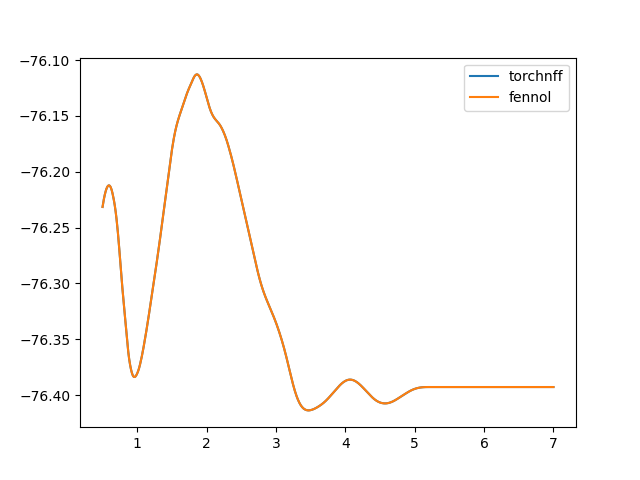

In [30]:
species = torch.tensor([8, 1, 1], dtype=torch.long)

### generate geometries
nsamples = 1000
distances = torch.linspace(0.5, 7.0, nsamples)
angle = 104.52
d_eq = 0.9572
# angle=92.11
# d_eq=1.33
symmetric = True
ref_last = False

species_ = species.unsqueeze(0).repeat(nsamples, 1)

coords = []
for d in distances:
    d2 = d if symmetric else d_eq
    coords.append(torch.from_numpy(generate_water(d, d2, angle)).float())
coords = torch.stack(coords).float()
print(coords.shape,)

_,e_tnff = model_tnff((species_,coords)) #.total_energy(terms=["energy"])
plt.figure()
plt.plot(distances.numpy(),e_tnff.detach().numpy(),label="torchnff")

species_ = species_.flatten().numpy()
coords = coords.flatten(0,1).numpy()
natoms = np.array([3]*nsamples)
e_fnl,out_fnl = model_test.total_energy(**{"species":species_,"coordinates":coords,"natoms":natoms})
plt.plot(distances.numpy(),e_fnl,label="fennol")

plt.legend()